# Parametric Model Example

In [1]:
# Setup
%matplotlib inline
from scipy import stats
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')

This is an implementation of the algorithm given in [the paper by Shahriari et al.](https://www.cs.ox.ac.uk/people/nando.defreitas/publications/BayesOptLoop.pdf), section 2, part A. The description below uses notation that I find more intuitive than what is used in the paper.

Suppose there are $K$ slot machines, which cause a player to "win" with some unknown probability or lose. The $K$ machines each have different win probabilities; so we are considering unknown $p_x$, for $x = 1, \ldots, K$. Now suppose that we sequentially play using these machines in an effort to determine which machine is best. That is, we want to find:
$$\text{\argmax}_x f(x) = p_x$$

The way this is acheived is by first assigning a prior distribution to the function we are trying to maximize. Since this function has a finite domain, this is equivalent to putting a prior distribution on each of the possible values of $f(x)$; that is, on each $p_x$. Here we will use iid Beta$(\alpha, \beta)$ priors on each $p_x$.

On each iteration, we will sample a value of $p_x$ from its current distribution for each $x$, choose the $x$ which gives us the largest sampled value, and "play" the associated slot machine (draw from a Bernoulli distribution with parameter $p = p_x$). We then update the current distribution of $p_x$ via Bayes rule; because the Beta distribution is the conjugate prior for the $p$ parameter in the Bernoulli, this amounts to simply adding $1$ to one of the parameters of the distribution; it remains Beta-distributed.

We can stop the algorithm after any number of iterations. Our guess for the best slot machine at this point will be the one corresponding to the $p_x$ with the highest posterior mean.

This program demonstrates this algorithm by taking as input a user-provided function and optimizing it in this way. We require several input values before running this program: the hyperparameters of the Beta prior $\alpha, \beta$ and the actual function we are optimizing, expressed as a vector of probaiblities. The number of possible options, $K$, is inferred from this probability vector. Assuming we don't want to run this program until the end of time, we will also require a stopping criterion, which in this case will be a set number of iterations $N$.

The first function returns the posterior parameters $\alpha$ and $\beta$ for each of the $K$ possible input values. The second returns its estimate of the maximizer of $f(x) = p_x$ at the end of $N$ iterations, found using the posterior mean as discussed above.

In [2]:
def param_bandit_ab(N, alpha, beta, real_p_vals):
    K = len(real_p_vals)
    np.random.seed(0)
    
    n0 = np.zeros(K)
    n1 = np.zeros(K)
    
    for i in range(N):
        # Acquisition phase: Choosing which argument to try next.
        sampled_p_vals = np.empty(K)
        for x in range(K):
            sampled_p_vals[x] = stats.beta.rvs(a=alpha + n1[x],
                                               b=beta + n0[x])
        x_val = sampled_p_vals.argmax()
            
        # Evaluation phase
        # Simulate a new y-valuefrom the Bernoulli distribution
        # associated with the largest px found in the acquisition phase
        y_val = stats.bernoulli.rvs(p=real_p_vals[x_val])
            
        # Update phase: Going from this iteration's prior distribution on
        # f to the posterior.
        if y_val == 0:
            n0[x_val] += 1
        else:
            n1[x_val] += 1
            
    return (alpha + n1, beta + n0)

def param_bandit(N, alpha, beta, real_p_vals):
    post_alpha, post_beta = param_bandit_ab(N, alpha, beta, real_p_vals)
    final_means = post_alpha / (post_alpha + post_beta)
    return final_means.argmax()

Now I will run this using iid Beta$(2, 2)$ prior distributions for each of $p_1, \ldots, p_4$. Below is a plot of this prior.

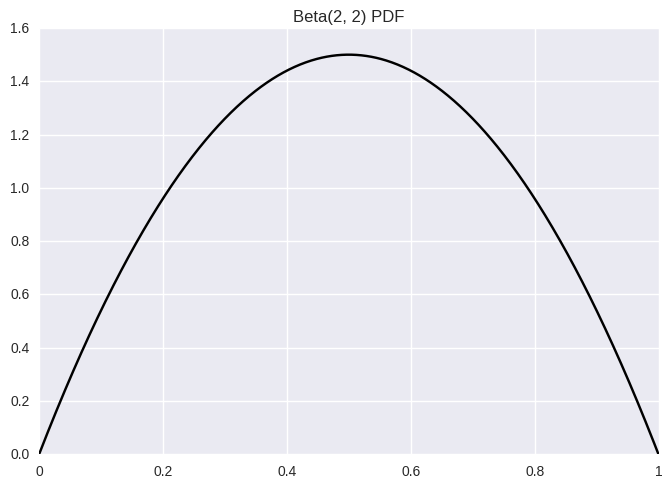

In [3]:
input_range = np.linspace(start=0, stop=1, num=1000)

fig, ax = sns.plt.subplots()
sns.plt.plot(stats.beta.pdf(input_range, a=2, b=2), color = 'k')
sns.plt.title('Beta(2, 2) PDF')
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1]);

After 20 iterations, we get:

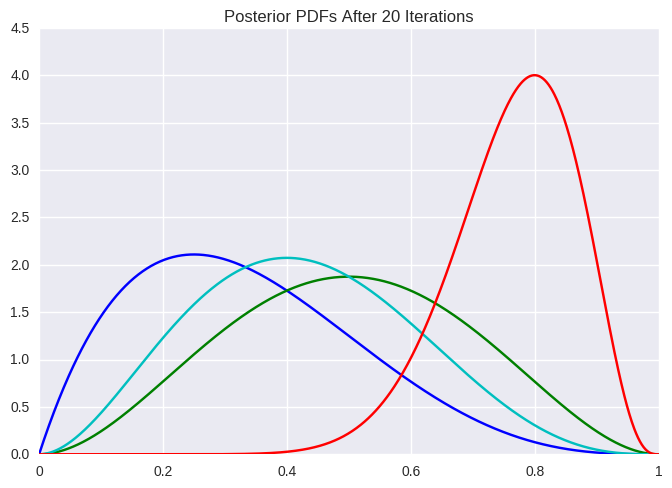

In [4]:
results = param_bandit_ab(20, 2, 2, [.1, .2, .65, .8])

fig, ax = sns.plt.subplots()
sns.plt.plot(stats.beta.pdf(input_range, a=results[0][0], b=results[1][0]), color = 'b')
sns.plt.plot(stats.beta.pdf(input_range, a=results[0][1], b=results[1][1]), color = 'g')
sns.plt.plot(stats.beta.pdf(input_range, a=results[0][2], b=results[1][2]), color = 'c')
sns.plt.plot(stats.beta.pdf(input_range, a=results[0][3], b=results[1][3]), color = 'r')
sns.plt.title('Posterior PDFs After 20 Iterations')
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1]);

And after 2000 iterations, the posteriors are as follows:

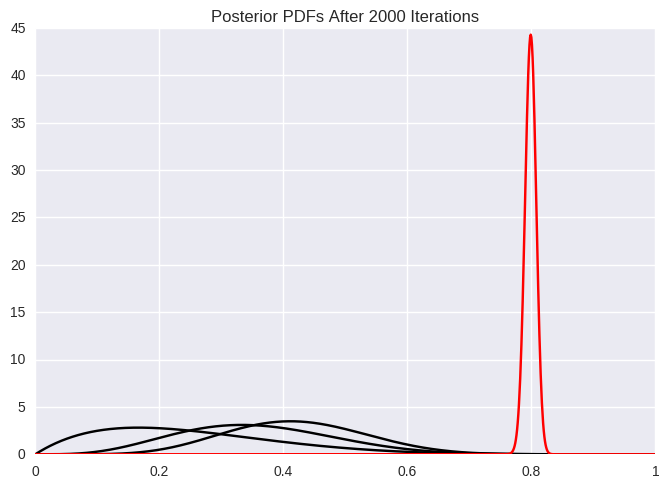

In [5]:
results = param_bandit_ab(2000, 2, 2, [.1, .2, .65, .8])

fig, ax = sns.plt.subplots()
for i in range(3):
    sns.plt.plot(stats.beta.pdf(input_range, a=results[0][i], b=results[1][i]), color = 'k')
sns.plt.plot(stats.beta.pdf(input_range, a=results[0][3], b=results[1][3]), color = 'r')
sns.plt.title('Posterior PDFs After 2000 Iterations')
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1]);

Not surprisingly given these posteriors, the option corresponding to $p_x = 0.8 $ is selected as the best one.

In [6]:
param_bandit(20000, 2, 2, [.1, .2, .65, .8])

3